# timeseries

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.timeseries.fillna(-1))
%timeit big_ts.vbt.timeseries.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
8.09 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
4.7 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.timeseries.fshift(3))
%timeit big_ts.vbt.timeseries.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.67 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
3.42 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.timeseries.diff())
%timeit big_ts.vbt.timeseries.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
6.85 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
5.58 ms ± 871 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(ts.pct_change())
%timeit big_ts.pct_change()

print(ts.vbt.timeseries.pct_change())
%timeit big_ts.vbt.timeseries.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  0.0
2018-01-04  0.333333 -0.333333  0.0
2018-01-05  0.000000 -0.500000 -0.5
271 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
5.59 ms ± 98.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.timeseries.ffill())
%timeit big_ts.vbt.timeseries.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
5.75 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
8.09 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
ts

,a,b,c
2018-01-01,1.0,NaN,1.0
2018-01-02,2.0,4.0,2.0
2018-01-03,3.0,3.0,NaN
2018-01-04,4.0,2.0,2.0
2018-01-05,NaN,1.0,1.0


In [11]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.timeseries.cumsum())
%timeit big_ts.vbt.timeseries.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
12.1 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
9.09 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.timeseries.cumprod())
%timeit big_ts.vbt.timeseries.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
11.7 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.83 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.timeseries.rolling_min(2))
%timeit big_ts.vbt.timeseries.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
43.6 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
15.5 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.timeseries.rolling_max(2))
%timeit big_ts.vbt.timeseries.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
43.8 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
14.5 ms ± 888 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.timeseries.rolling_mean(2))
%timeit big_ts.vbt.timeseries.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
30.2 ms ± 522 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
15.8 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.timeseries.rolling_std(2))
%timeit big_ts.vbt.timeseries.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
82.6 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
24.6 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
print(ts.ewm(span=2, min_periods=2).mean())
%timeit big_ts.ewm(span=2, min_periods=2).mean()

print(ts.vbt.timeseries.ewm_mean(2))
%timeit big_ts.vbt.timeseries.ewm_mean(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
93.6 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
26.4 ms ± 9.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(ts.ewm(span=2, min_periods=2).std())
%timeit big_ts.ewm(span=2, min_periods=2).std()

print(ts.vbt.timeseries.ewm_std(2))
%timeit big_ts.vbt.timeseries.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
575 ms ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
25.1 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(ts.expanding().min())
%timeit big_ts.expanding().min()

print(ts.vbt.timeseries.expanding_min())
%timeit big_ts.vbt.timeseries.expanding_min()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
49.4 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
11.2 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.timeseries.expanding_max())
%timeit big_ts.vbt.timeseries.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
47.1 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
8.63 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(ts.expanding().mean())
%timeit big_ts.expanding().mean()

print(ts.vbt.timeseries.expanding_mean())
%timeit big_ts.vbt.timeseries.expanding_mean()

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
30.5 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
14.8 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(ts.expanding().std())
%timeit big_ts.expanding().std()

print(ts.vbt.timeseries.expanding_std())
%timeit big_ts.vbt.timeseries.expanding_std()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
58.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
21.8 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
pd_nanmean_nb = njit(lambda x: np.nanmean(x))
nanmean_nb = njit(lambda col, i, x: np.nanmean(x))
nanmean_matrix_nb = njit(lambda i, x: np.nanmean(x))

In [24]:
print(ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.timeseries.rolling_apply(2, nanmean_nb))
%timeit big_ts.vbt.timeseries.rolling_apply(2, nanmean_nb)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
406 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
60.9 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
7.01 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb)

print(ts.vbt.timeseries.expanding_apply(nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_matrix_nb, on_matrix=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.91 s ± 540 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
867 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
826 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: pd_nanmean_nb(x.values), 
    'b': lambda x: pd_nanmean_nb(x.values), 
    'c': lambda x: pd_nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_matrix_nb, on_matrix=True)

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.68 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.02 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
10.3 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0
6.1 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
118 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
114 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2

In [28]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
115 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
115 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2

In [29]:
print(ts['a'].resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float32
3.88 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
8.87 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.45 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
92.8 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01  2.285714  2.285714  2.285714
2018-01-04  2.000000  2.000000  2.000000
14.4 ms ± 76.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
print(ts['a'].resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float32
7.11 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
9.69 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
2.49 s ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
45.7 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-07  2.166667  2.166667  2.166667
14.5 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
print(ts['a'].vbt.timeseries.rolling_window(2, n=2))
%timeit big_ts.iloc[:, 0].vbt.timeseries.rolling_window(2, n=100)

print(ts.vbt.timeseries.rolling_window(2, n=2))
%timeit big_ts.vbt.timeseries.rolling_window(2, n=100)

start_date  2018-01-01  2018-01-04
0                  1.0         4.0
1                  2.0         NaN
785 µs ± 177 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                    a                     b                     c           
start_date 2018-01-01 2018-01-04 2018-01-01 2018-01-04 2018-01-01 2018-01-04
0                 1.0        4.0        NaN        2.0        1.0        2.0
1                 2.0        NaN        4.0        1.0        2.0        1.0
45.8 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
mult_nb = njit(lambda col, i, x: x * 2)

print(ts.applymap(lambda x: x * 2))
%timeit big_ts.applymap(lambda x: x * 2)

print(ts['a'].vbt.timeseries.applymap(mult_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.applymap(mult_nb)

print(ts.vbt.timeseries.applymap(mult_nb))
%timeit big_ts.vbt.timeseries.applymap(mult_nb)

              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
428 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    2.0
2018-01-02    4.0
2018-01-03    6.0
2018-01-04    8.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
297 µs ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
10.9 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
greater_nb = njit(lambda col, i, x: x > 2)

print(ts.applymap(lambda x: x if x > 2 else np.nan))
%timeit big_ts.applymap(lambda x: x if x > 2 else np.nan)

print(ts['a'].vbt.timeseries.filter(greater_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.filter(greater_nb)

print(ts.vbt.timeseries.filter(greater_nb))
%timeit big_ts.vbt.timeseries.filter(greater_nb)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
461 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    NaN
2018-01-02    NaN
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
312 µs ± 87 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
11.8 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(ts.vbt.timeseries.timedelta)

1 days 00:00:00


In [11]:
every_2th_nb = njit(lambda col, a: a[::2])
sum_nb = njit(lambda col, a: np.nansum(a))

print(ts['a'].vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True))
%timeit big_ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True)

4.0
432 µs ± 99.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    4.0
b    4.0
c    2.0
dtype: float64
2.4 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
11 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(ts.apply(np.nansum, axis=0))
%timeit big_ts.apply(np.nansum, axis=0)

print(ts['a'].vbt.timeseries.reduce(sum_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.reduce(sum_nb)

print(ts.vbt.timeseries.reduce(sum_nb))
%timeit big_ts.vbt.timeseries.reduce(sum_nb)

print(ts.vbt.timeseries.reduce(sum_nb, time_units=True))
%timeit big_ts.vbt.timeseries.reduce(sum_nb, time_units=True)

a    10.0
b    10.0
c     6.0
dtype: float64
94.1 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.0
457 µs ± 71.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a    10.0
b    10.0
c     6.0
dtype: float64
3.14 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   10 days
b   10 days
c    6 days
dtype: timedelta64[ns]
11.5 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
@njit
def min_and_max_nb(col, a):
    result = np.empty(2)
    result[0] = np.nanmin(a)
    result[1] = np.nanmax(a)
    return result

print(ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0))
%timeit big_ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0)

print(ts['a'].vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.iloc[:, 0].vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True))
%timeit big_ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True)

     a    b    c
0  1.0  1.0  1.0
1  4.0  4.0  2.0
199 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
min    1.0
max    4.0
Name: a, dtype: float64
402 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
       a    b    c
min  1.0  1.0  1.0
max  4.0  4.0  2.0
5.26 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
         a      b      c
min 1 days 1 days 1 days
max 4 days 4 days 2 days
134 ms ± 940 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print(ts.min())
%timeit big_ts.min()

print(ts.vbt.timeseries.min())
%timeit big_ts.vbt.timeseries.min()

print(ts.vbt.timeseries.min(time_units=True))
%timeit big_ts.vbt.timeseries.min(time_units=True)

a    1.0
b    1.0
c    1.0
dtype: float32
3.85 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.0
b    1.0
c    1.0
dtype: float32
3.84 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days
b   1 days
c   1 days
dtype: timedelta64[ns]
11 ms ± 90.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(ts.max())
%timeit big_ts.max()

print(ts.vbt.timeseries.max())
%timeit big_ts.vbt.timeseries.max()

print(ts.vbt.timeseries.max(time_units=True))
%timeit big_ts.vbt.timeseries.max(time_units=True)

a    4.0
b    4.0
c    2.0
dtype: float32
3.83 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4.0
b    4.0
c    2.0
dtype: float32
3.83 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
11.2 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(ts.mean())
%timeit big_ts.mean()

print(ts.vbt.timeseries.mean())
%timeit big_ts.vbt.timeseries.mean()

print(ts.vbt.timeseries.mean(time_units=True))
%timeit big_ts.vbt.timeseries.mean(time_units=True)

a    2.5
b    2.5
c    1.5
dtype: float32
2.92 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.5
b    2.5
c    1.5
dtype: float32
2.88 ms ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2 days 12:00:00
b   2 days 12:00:00
c   1 days 12:00:00
dtype: timedelta64[ns]
10.5 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(ts.std())
%timeit big_ts.std()

print(ts.vbt.timeseries.std())
%timeit big_ts.vbt.timeseries.std()

print(ts.vbt.timeseries.std(time_units=True))
%timeit big_ts.vbt.timeseries.std(time_units=True)

a    1.290994
b    1.290994
c    0.577350
dtype: float32
3.99 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.290994
b    1.290994
c    0.577350
dtype: float32
4 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days 06:59:01.916656
b   1 days 06:59:01.916656
c   0 days 13:51:23.062363
dtype: timedelta64[ns]
11.6 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print((~ts.isnull()).sum())
%timeit (~big_ts.isnull()).sum()

print(ts.vbt.timeseries.count())
%timeit big_ts.vbt.timeseries.count()

print(ts.vbt.timeseries.count(time_units=True))
%timeit big_ts.vbt.timeseries.count(time_units=True)

a    4
b    4
c    4
dtype: int64
2.6 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4
b    4
c    4
dtype: int64
2 ms ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   4 days
dtype: timedelta64[ns]
9.49 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(ts.idxmin())
%timeit big_ts.idxmin()

print(ts.vbt.timeseries.argmin())
%timeit big_ts.vbt.timeseries.argmin()

a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
13.5 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
3.41 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(ts.idxmax())
%timeit big_ts.idxmax()

print(ts.vbt.timeseries.argmax())
%timeit big_ts.vbt.timeseries.argmax()

a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
13.7 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
3.44 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(ts.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.describe(percentiles=np.arange(0, 1, 0.1))

print(ts.vbt.timeseries.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.vbt.timeseries.describe(percentiles=np.arange(0, 1, 0.1))

              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500000  1.50000
60%    2.800000  2.800000  1.80000
70%    3.100000  3.100000  2.00000
80%    3.400000  3.400000  2.00000
90%    3.700000  3.700000  2.00000
max    4.000000  4.000000  2.00000
1.92 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
               a         b        c
count   4.000000  4.000000  4.00000
mean    2.500000  2.500000  1.50000
std     1.290994  1.290994  0.57735
min     1.000000  1.000000  1.00000
0.00%   1.000000  1.000000  1.00000
10.00%  1.300000  1.300000  1.00000
20.00%  1.600000  1.600000  1.00000
30.00%  1.900000  1.900000  1.00000
40.00%  2.200000  2.200000  1.20000
50.00%  2.50

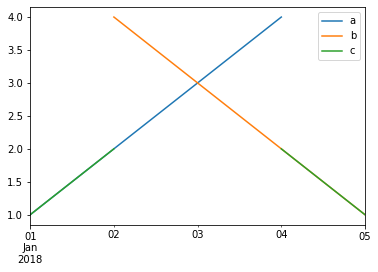

In [22]:
# Two ways of plotting
ts.plot()

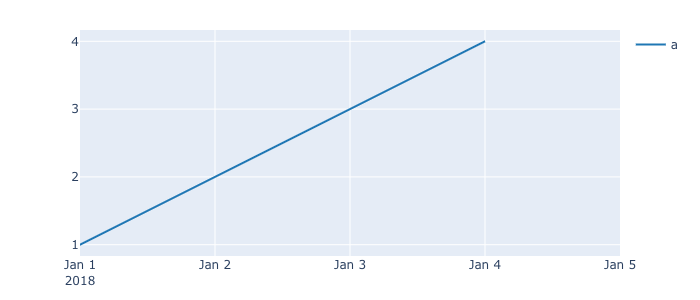

In [23]:
ts['a'].vbt.timeseries.plot().show_png()

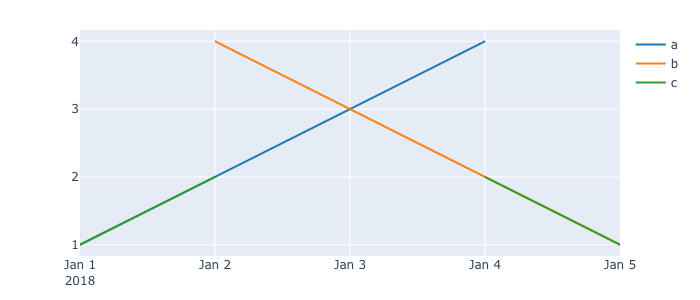

In [24]:
ts.vbt.timeseries.plot().show_png()

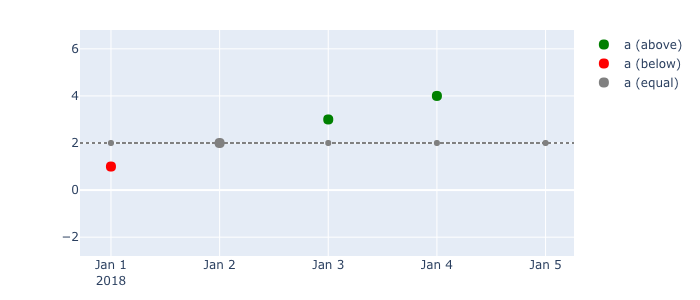

In [25]:
ts['a'].vbt.timeseries.plot_against(2).show_png()

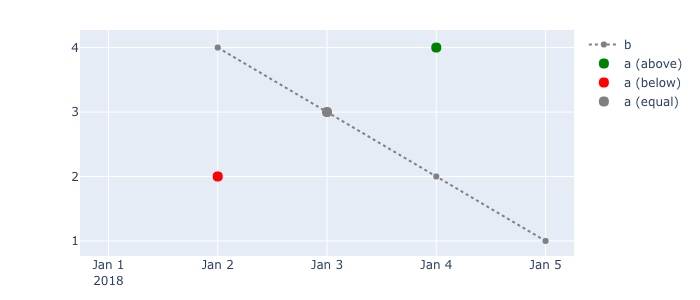

In [26]:
ts['a'].vbt.timeseries.plot_against(ts['b']).show_png()

## OHLCV

In [27]:
ohlcv_ts = pd.DataFrame(
    columns=['Open', 'High', 'Low', 'Close', 'Volume'],
    index=[datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
)
ohlcv_ts['Open'] = np.cumsum(np.random.uniform(-0.8, 1, size=(1000,)))
ohlcv_ts['Close'] = ohlcv_ts['Open'] + np.random.uniform(-1, 1, size=(1000,))
ohlcv_ts['High'] = ohlcv_ts['Open'] + np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Low'] = ohlcv_ts['Open'] - np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Volume'] = np.cumsum(np.random.uniform(-1, 1, size=(1000,)))

print(ohlcv_ts.head())

                Open      High       Low     Close    Volume
2018-01-01 -0.215861  0.550554 -1.006720 -0.207495  0.722158
2018-01-02  0.351140  1.070810 -0.129642  1.125355  0.808357
2018-01-03  0.940280  1.363845  0.028976  1.857904  1.637592
2018-01-04  0.433441  1.108908  0.314202  1.062072  0.903379
2018-01-05  0.758673  1.702985  0.472758  0.636532  0.569715


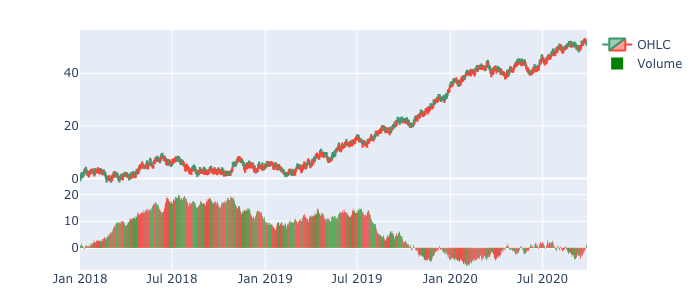

In [28]:
ohlcv_ts = ohlcv_ts.rename(columns={'Volume': 'Volume2'}) # test different column names

ohlcv_ts.vbt.ohlcv(volume='Volume2').plot().show_png()